# Inventory Dynamics

----

#### John Stachurski
#### Prepared for the CBC Computational Workshop (May 2024)

----

## Overview

This lecture explores s-S inventory dynamics.

We also studied this model in an earlier notebook using NumPy.

Here we study the same problem using JAX.

One issue we will consider is whether or not we can improve execution speed by using JAX's `fori_loop` function (as a replacement for looping in Python).

We will use the following imports:

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import jax
import jax.numpy as jnp
from jax import random, lax
from collections import namedtuple

Here’s a description of our GPU:

In [2]:
!nvidia-smi

Wed May 15 08:56:05 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3080        Off |   00000000:3E:00.0 Off |                  N/A |
| 30%   29C    P8             25W /  320W |       6MiB /  10240MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

/home/john/anaconda3/lib/python3.11/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


## Model

We briefly recall the dynamics.

Let $a \vee b = \max\{a, b\}$

Consider a firm with inventory $ X_t $.

The firm waits until $ X_t \leq s $ and then restocks up to $ S $ units.

It faces stochastic demand $ \{ D_t \} $, which we assume is IID across time and
firms.

$$
X_{t+1} =
    \begin{cases}
      (S - D_{t+1}) \vee  0 & \quad \text{if } X_t \leq s \\
      (X_t - D_{t+1}) \vee 0 &  \quad \text{if } X_t > s
    \end{cases}
$$

In what follows, we will assume that each $ D_t $ is lognormal, so that

$$
D_t = \exp(\mu + \sigma Z_t)
$$

where $ \mu $ and $ \sigma $ are parameters and $ \{Z_t\} $ is IID
and standard normal.

Here’s a `namedtuple` that stores parameters.

In [3]:
Parameters = namedtuple('Parameters', ('s', 'S', 'μ', 'σ'))

# Create a default instance
params = Parameters(s=10, S=100, μ=1.0, σ=0.5)

## Cross-sectional distributions

Let's simulate the inventories of a cross-section of firms.

We will use the following code to update the cross-section by one period.

In [4]:
@jax.jit
def update_cross_section(params, X_vec, D):
    """
    Update by one period a cross-section of firms with inventory levels 
    X_vec, given the vector of demand shocks in D.

       * X_vec[i] is the inventory of firm i
       * D[i] is the demand shock for firm i 

    """
    # Unpack
    s, S = params.s, params.S
    # Restock if the inventory is below the threshold
    X_new = jnp.where(X_vec <= s, 
                      jnp.maximum(S - D, 0), jnp.maximum(X_vec - D, 0))
    return X_new

### For loop version

Now we provide code to compute the cross-sectional distribution $ \psi_T $ given some
initial distribution $ \psi_0 $ and a positive integer $ T $.

In this code we use an ordinary Python `for` loop to step forward through time

While Python loops are slow, this approach is reasonable here because
efficiency of outer loops has far less influence on runtime than efficiency of inner loops.

(Below we will squeeze out more speed by compiling the outer loop as well as the
update rule.)

In the code below, the initial distribution $ \psi_0 $ takes all firms to have
initial inventory `x_init`.

In [5]:
def compute_cross_section(params, x_init, T, key, num_firms=50_000):
    # Unpack
    μ, σ = params.μ, params.σ
    # Set up initial distribution
    X = jnp.full((num_firms, ), x_init)
    # Loop
    for i in range(T):
        Z = random.normal(key, shape=(num_firms, ))
        D = jnp.exp(params.μ + params.σ * Z)
        X = update_cross_section(params, X, D)
        key = random.fold_in(key, i)

    return X

We’ll use the following specification

In [6]:
x_init = 50
T = 500
# Initialize random number generator
key = random.PRNGKey(10)

Let’s look at the timing.

In [7]:
%time X_vec = compute_cross_section(params, x_init, T, key).block_until_ready()

CPU times: user 543 ms, sys: 74.9 ms, total: 618 ms
Wall time: 473 ms


In [8]:
%time X_vec = compute_cross_section(params, x_init, T, key).block_until_ready()

CPU times: user 365 ms, sys: 48.5 ms, total: 414 ms
Wall time: 264 ms


Here’s a histogram of inventory levels at time $ T $.

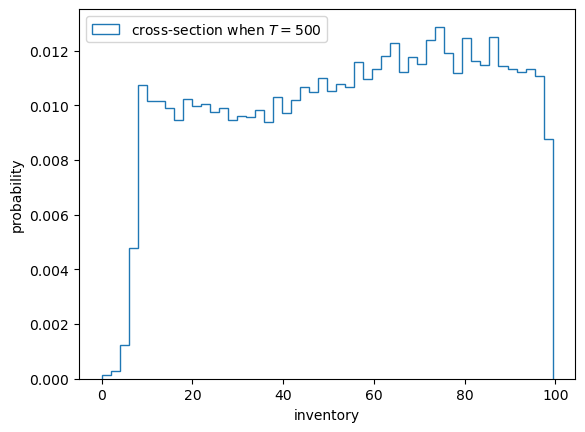

In [9]:
fig, ax = plt.subplots()
ax.hist(X_vec, bins=50, 
        density=True, 
        histtype='step', 
        label=f'cross-section when $T = {T}$')
ax.set_xlabel('inventory')
ax.set_ylabel('probability')
ax.legend()
plt.show()

### Compiling the outer loop

Now let’s see if we can gain some speed by compiling the outer loop, which steps
through the time dimension.

We will do this using `jax.jit` and a `fori_loop`, which is a compiler-ready version of a `for` loop provided by JAX.

In [10]:
def compute_cross_section_fori(params, x_init, T, key, num_firms=50_000):

    s, S, μ, σ = params.s, params.S, params.μ, params.σ

    # Define the function for each update
    def fori_update(t, state):
        # Unpack
        X, key = state
        # Draw shocks using key
        Z = random.normal(key, shape=(num_firms,))
        D = jnp.exp(μ + σ * Z)
        # Update X
        X = jnp.where(X <= s,
                  jnp.maximum(S - D, 0),
                  jnp.maximum(X - D, 0))
        # Refresh the key
        key = random.fold_in(key, t)
        new_state = X, key
        return new_state

    # Loop t from 0 to T, applying fori_update each time.
    X = jnp.full((num_firms, ), x_init)
    initial_state = X, key
    X, key = lax.fori_loop(0, T, fori_update, initial_state)

    return X

# Compile taking T and num_firms as static (changes trigger recompile)
compute_cross_section_fori = jax.jit(
    compute_cross_section_fori, static_argnums=(2, 4))

Let’s see how fast this runs with compile time.

In [11]:
%time X_vec = compute_cross_section_fori(params, x_init, T, key).block_until_ready()

CPU times: user 190 ms, sys: 10.6 ms, total: 201 ms
Wall time: 125 ms


And let’s see how fast it runs without compile time.

In [12]:
%time X_vec = compute_cross_section_fori(params, x_init, T, key).block_until_ready()

CPU times: user 8.99 ms, sys: 0 ns, total: 8.99 ms
Wall time: 10.7 ms


Compared to the original version with a pure Python outer loop, we have
produced a nontrivial speed gain.

This is due to the fact that we have compiled the whole operation.

Let's check that we get a similar cross-section.

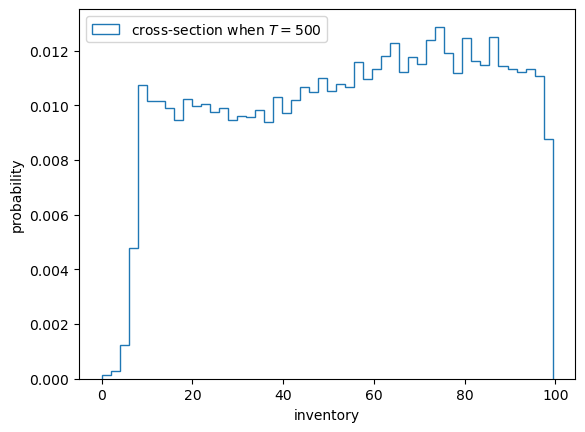

In [13]:
fig, ax = plt.subplots()
ax.hist(X_vec, bins=50, 
        density=True, 
        histtype='step', 
        label=f'cross-section when $T = {T}$')
ax.set_xlabel('inventory')
ax.set_ylabel('probability')
ax.legend()
plt.show()

### Further vectorization

For relatively small problems, we can make this code run even faster by generating
all random variables at once.

This improves efficiency because we are taking more operations out of the loop.

In [14]:
def compute_cross_section_fori(params, x_init, T, key, num_firms=50_000):

    s, S, μ, σ = params.s, params.S, params.μ, params.σ
    X = jnp.full((num_firms, ), x_init)
    Z = random.normal(key, shape=(T, num_firms))
    D = jnp.exp(μ + σ * Z)

    def update_cross_section(i, X):
        X = jnp.where(X <= s,
                  jnp.maximum(S - D[i, :], 0),
                  jnp.maximum(X - D[i, :], 0))
        return X

    X = lax.fori_loop(0, T, update_cross_section, X)

    return X

# Compile taking T and num_firms as static (changes trigger recompile)
compute_cross_section_fori = jax.jit(
    compute_cross_section_fori, static_argnums=(2, 4))

Let’s test it with compile time included.

In [15]:
%time X_vec = compute_cross_section_fori(params, x_init, T, key).block_until_ready()

CPU times: user 104 ms, sys: 0 ns, total: 104 ms
Wall time: 108 ms


Let’s run again to eliminate compile time.

In [16]:
%time X_vec = compute_cross_section_fori(params, x_init, T, key).block_until_ready()

CPU times: user 2.3 ms, sys: 0 ns, total: 2.3 ms
Wall time: 4.95 ms


On one hand, this version is faster than the previous one, where random variables were
generated inside the loop.

On the other hand, this implementation consumes far more memory, as we need to
store large arrays of random draws.

The high memory consumption becomes problematic for large problems.

## Restock frequency

As an exercise, let’s study the probability that firms need to restock over a given time period.

In the exercise, we will

- set the starting stock level to $ X_0 = 70 $ and  
- calculate the proportion of firms that need to order twice or more in the first 50 periods.  


This proportion approximates the probability of the event when the sample size
is large.

### For loop version

We start with an easier `for` loop implementation

In [17]:
# Define a jitted function for each update
@jax.jit
def update_stock(params, counter, X, D):
    s, S = params.s, params.S
    X = jnp.where(X <= s,
                  jnp.maximum(S - D, 0),
                  jnp.maximum(X - D, 0))
    counter = jnp.where(X <= s, counter + 1, counter)
    return counter, X

def compute_freq(params, key,
                 x_init=70,
                 sim_length=50,
                 num_firms=1_000_000):

    # Prepare initial arrays
    X = jnp.full((num_firms, ), x_init)
    counter = jnp.zeros((num_firms, ))

    # Use a for loop to perform the calculations on all states
    for i in range(sim_length):
        Z = random.normal(key, (num_firms, ))
        D = jnp.exp(params.μ + params.σ * Z)
        counter, X = update_stock(params, counter, X, D)
        key = random.fold_in(key, i)

    return jnp.mean(counter > 1, axis=0)

In [18]:
key = random.PRNGKey(42)

In [19]:
%time freq = compute_freq(params, key).block_until_ready()
print(f"Frequency of at least two stock outs = {freq}")

CPU times: user 301 ms, sys: 2.74 ms, total: 303 ms
Wall time: 315 ms
Frequency of at least two stock outs = 0.5549740195274353


In [20]:
%time freq = compute_freq(params, key).block_until_ready()
print(f"Frequency of at least two stock outs = {freq}")

CPU times: user 33.3 ms, sys: 9.56 ms, total: 42.9 ms
Wall time: 30 ms
Frequency of at least two stock outs = 0.5549740195274353


### Exercise 4.1

Write a `fori_loop` version of the last function.  See if you can increase the
speed while generating a similar answer.

### Solution to[ Exercise 4.1](https://jax.quantecon.org/#inventory_dynamics_ex1)

Here is a `fori_loop` version that JIT compiles the whole function

In [21]:
def compute_freq_fori_loop(params, 
                 key,
                 x_init=70,
                 sim_length=50,
                 num_firms=1_000_000):

    s, S, μ, σ = params
    Z = random.normal(key, shape=(sim_length, num_firms))
    D = jnp.exp(μ + σ * Z)

    # Define the function for each update
    def update(t, state):
        # Separate the inventory and restock counter
        X, counter = state
        X = jnp.where(X <= s,
                      jnp.maximum(S - D[t, :], 0),
                      jnp.maximum(X - D[t, :], 0))
        counter = jnp.where(X <= s, counter + 1, counter)
        return X, counter

    X = jnp.full((num_firms, ), x_init)
    counter = jnp.zeros(num_firms)
    initial_state = X, counter
    X, counter = lax.fori_loop(0, sim_length, update, initial_state)

    return jnp.mean(counter > 1)

compute_freq_fori_loop = jax.jit(compute_freq_fori_loop, static_argnums=((3, 4)))

Note the time the routine takes to run, as well as the output

In [22]:
%time freq = compute_freq_fori_loop(params, key).block_until_ready()

CPU times: user 185 ms, sys: 11.2 ms, total: 196 ms
Wall time: 159 ms


In [23]:
%time freq = compute_freq_fori_loop(params, key).block_until_ready()

CPU times: user 1.02 ms, sys: 294 µs, total: 1.31 ms
Wall time: 4.26 ms


In [24]:
print(f"Frequency of at least two stock outs = {freq}")

Frequency of at least two stock outs = 0.5542809963226318
